### About
- This notebook summarize the following datasets.
    - [NYU Depth Dataset V2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)

In [ ]:
import os
import numpy as np
from pathlib import Path
import re
from imageio import imread
from skimage import transform
import shutil
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch
import random
from IPython.core.pylabtools import figsize

%matplotlib inline

### Split samples
- 590 samples in total
    - 400 for training
    - 190 for validation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/nyu_depth_v2_raw'
samples = os.listdir(data_dir)
print('Number of sampels: ', len(samples))

Number of sampels:  3153


### Example room

In [ ]:
#sample = 'living_room_0044'
files = samples

pgms = [f for f in files if '.pgm' in f and 'd-' in f]
ppms = [f for f in files if '.ppm' in f and 'r-' in f]

print('number of pgms:', len(pgms), ' number of ppms:', len(ppms))

number of pgms: 1664  number of ppms: 1488


### Read .pgm images
- Reference
    - https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm

In [ ]:
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

### Depth image sample
- .pgm format
- filename with prefix d-

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


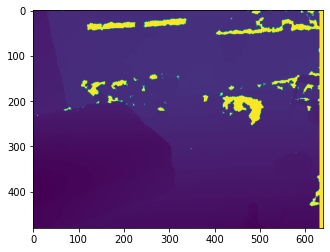

[[ 928  928  928 ... 2047 2047 2047]
 [ 928  928  928 ... 2047 2047 2047]
 [ 928  928  928 ... 2047 2047 2047]
 ...
 [ 855  856  857 ... 2047 2047 2047]
 [ 856  856  858 ... 2047 2047 2047]
 [ 856  856  857 ... 2047 2047 2047]]
image shape resized:  (74, 55) image type:  <class 'numpy.ndarray'>


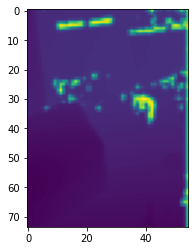

[[0.01418822 0.01423667 0.01456657 ... 0.02653516 0.02158749 0.02683656]
 [0.01420615 0.01425193 0.01453838 ... 0.01846158 0.0183528  0.0259383 ]
 [0.01423667 0.01426719 0.01450786 ... 0.01666256 0.01658947 0.02575983]
 ...
 [0.01309224 0.01313802 0.01318379 ... 0.01345846 0.01414009 0.02502064]
 [0.01308184 0.01313802 0.01319905 ... 0.01341268 0.01409864 0.02500191]
 [0.01309224 0.01315328 0.01321431 ... 0.01337824 0.01406812 0.02500066]]


In [ ]:
for pgm in pgms[:1]:
    image = read_pgm(data_dir + '/'+ pgm, byteorder='<')
    print('image shape: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()
    
    print(image)
    
    image = transform.resize(image, (74, 55))
    print('image shape resized: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()
    
    print(image)

### RGB image sample
- .ppm format
- filename with prefix r-

image shape:  (480, 640, 3) image type:  <class 'numpy.ndarray'>


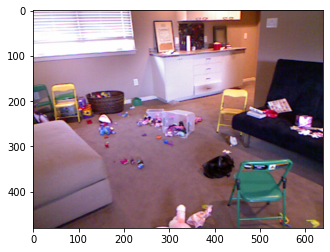

image shape resized:  (304, 228, 3) image type:  <class 'numpy.ndarray'>


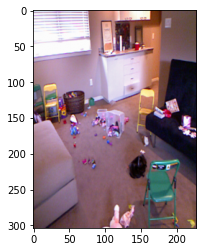

image shape resized:  (74, 55, 3) image type:  <class 'numpy.ndarray'>


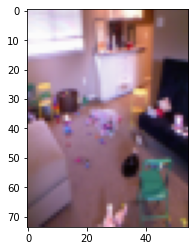

In [ ]:
for ppm in ppms[:1]:
    image = imread(data_dir + '/' + ppm)
    image = np.array(image)
    print('image shape: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()
    
    image = transform.resize(image, (304,  228))
    print('image shape resized: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()
    
    image = transform.resize(image, (74, 55))
    print('image shape resized: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()

### Split train/valid data

In [ ]:
train_rgb = Path('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/train/rgb')
train_depth = Path('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/train/depth')

valid_rgb = Path('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/valid/rgb')
valid_depth = Path('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/valid/depth')

if os.path.exists(train_rgb) or os.path.exists(train_depth):
    shutil.rmtree(train_rgb)
    shutil.rmtree(train_depth)
os.makedirs(train_rgb)
os.makedirs(train_depth)

if os.path.exists(valid_rgb) or os.path.exists(valid_depth):
    shutil.rmtree(valid_rgb)
    shutil.rmtree(valid_depth)
os.makedirs(valid_rgb)
os.makedirs(valid_depth)

In [ ]:
num_train = 400
num_train_real = 0
idx = 0
ss = []
for i, s in enumerate(samples):    
    
    rgb_samples = [f for f in os.listdir(data_dir) if '.ppm' in f and 'r-' in f]
    depth_samples = [f for f in os.listdir(data_dir) if '.pgm' in f and 'd-' in f]
    
    if abs(len(rgb_samples) - len(depth_samples)) > 10:
        ss.append(s)

    if not rgb_samples or not depth_samples:
        print('Empty folder: ', i, s)
        continue
    else:
        rgb_sample, depth_sample = rgb_samples[0], depth_samples[0]
    
    if i < num_train:
        shutil.copyfile(data_dir + "/" + rgb_sample, str(train_rgb) + "/" + '{}.ppm'.format(idx))
        shutil.copyfile(data_dir + '/' + depth_sample, str(train_depth) + '/' + '{}.pgm'.format(idx))
        num_train_real += 1
    else:
        shutil.copyfile(data_dir + '/' + rgb_sample, str(valid_rgb) + '/' + '{}.ppm'.format(idx - num_train_real))
        shutil.copyfile(data_dir + '/' + depth_sample, str(valid_depth) + '/' + '{}.pgm'.format(idx - num_train_real))
    
    idx += 1

print('finished')
print(len(ss))

finished
3153


In [ ]:
shutil.copyfile(valid_rgb / '68.ppm', valid_rgb / '67.ppm')
shutil.copyfile(valid_depth / '68.pgm', valid_depth / '67.pgm')

PosixPath('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/valid/depth/67.pgm')

seed:  2694039394
torch.Size([480, 640])


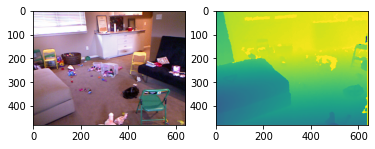

In [ ]:
a = Image.open('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/train/rgb/355.ppm')
b = Image.open('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/train/depth/355.pgm')

s = random.randint(0, 2 ** 32)
print('seed: ', s)
random.seed(s)
#a = transforms.RandomRotation(50)(a)

random.seed(s)
#b = transforms.RandomRotation(50)(b)

plt.subplot(121)
plt.imshow(a)

b = transforms.ToTensor()(b).view(480, 640)
print(b.size())
plt.subplot(122)
plt.imshow(b)

plt.show()

[[[253 245 254]
  [253 251 254]
  [253 252 254]
  ...
  [ 95  72  73]
  [ 95  67  91]
  [ 96  69  91]]

 [[253 251 254]
  [253 254 254]
  [253 253 254]
  ...
  [ 95  73  73]
  [ 95  69  91]
  [ 96  72  91]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [ 96  68  64]
  [ 96  66  71]
  [ 96  67  71]]

 ...

 [[ 79  61  53]
  [ 79  65  55]
  [ 80  61  57]
  ...
  [126  82  80]
  [119  81  80]
  [113  78  80]]

 [[ 79  62  51]
  [ 79  59  50]
  [ 80  59  49]
  ...
  [129  84  80]
  [119  86  82]
  [110  83  82]]

 [[ 79  58  50]
  [ 79  54  45]
  [ 80  57  41]
  ...
  [129  85  80]
  [119  84  84]
  [110  82  84]]]


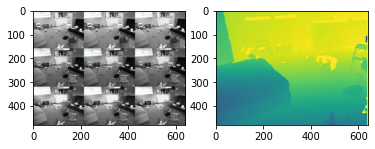

In [ ]:
a = Image.open('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/train/rgb/155.ppm')
b = Image.open('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/train/depth/155.pgm')

print(np.asarray(a))
a = transforms.ToTensor()(a).view(480, 640, 3)
plt.subplot(121)
plt.imshow(a)

b = transforms.ToTensor()(b).view(480, 640)
plt.subplot(122)
plt.imshow(b)

In [ ]:
a = torch.randn((30, 30))
b = torch.randn((3, 3))
a[1, 2] = 0
a[1, 1] = 0
b[1, 1] = 0
a.uniform_(-5, 5)
plt.hist(a)

In [ ]:
ma = (a == a.max())
mb = (b == b.min())
print(ma)
print(mb)

m = ma | mb
print(m)
print(~m)

In [ ]:
p = Path('../../../data')
pp = p / 'nyu_depth_v2_aligned'

ll = os.listdir(p / 'nyu_depth_v2_aligned')
print(len(ll))

if os.path.exists(p / 'train'):
    shutil.rmtree(p / 'train')
os.makedirs(p / 'train')

if os.path.exists(p / 'valid'):
    shutil.rmtree(p / 'valid')
os.makedirs(p / 'valid')

train_fi = 0
valid_fi = 0
for i, s in enumerate(ll):
    
    if i < 400:
        op = p / 'train'
    else:
        op = p / 'valid'
    
    print('>', end=' ')
    
    for fi in range(int(len(os.listdir(pp / s)) / 2)):
        
        if i < 400:
            shutil.move(pp / s / '{}.ppm'.format(fi), op / '{}.ppm'.format(train_fi))
            shutil.move(pp / s / '{}.pgm'.format(fi), op / '{}.pgm'.format(train_fi))
            train_fi += 1
        else:
            shutil.move(pp / s / '{}.ppm'.format(fi), op / '{}.ppm'.format(valid_fi))
            shutil.move(pp / s / '{}.pgm'.format(fi), op / '{}.pgm'.format(valid_fi))
            valid_fi += 1
    

510
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

### Move train/valid data (wasn't used and fixed)

In [ ]:
p0 = Path('../../../data/nyu_depth_v2_aligned')
pt0 = p0 / 'train'
pv0 = p0 / 'valid'

p1 = Path('../../../data/nyu')
pt1 = p1 / 'train'
pv1 = p1 / 'valid'

def move_files(pt0, pt1, t):
    
    i, j = 0, 0
    while os.path.exists(pt0 / 'rgb' / '{}.ppm'.format(i)):
        
        if os.path.getsize(pt0 / 'rgb' / '{}.ppm'.format(i)) > 0 and \
           os.path.getsize(pt0 / 'depth' / '{}.pgm'.format(i)) > 0:
            shutil.move(pt0 / 'rgb' / '{}.ppm'.format(i), pt1 / 'rgb' / '{}.ppm'.format(j))
            shutil.move(pt0 / 'depth' / '{}.pgm'.format(i), pt1 / 'depth' / '{}.pgm'.format(j))
            j += 1
        i += 1
    print(i, j)

move_files(pt0, pt1, 0)
move_files(pv0, pv1, 3)

343585 172236
97707 130


In [ ]:
p0 = Path('../../../data/nyu_depth_v2_aligned')
ps = os.listdir(p0)

p1 = Path('../../../data/nyu')
pt1 = p1 / 'train'
pv1 = p1 / 'valid'

def move_files(pt0, pt1, begin=0, end=len(ps)):
    
    j = 0
    for k, s in enumerate(ps):
        
        if k not in range(begin, end):
            continue
        
        i = 0
        while os.path.exists(p0 / s / '{}.ppm'.format(i)):

            if os.path.getsize(p0 / s / '{}.ppm'.format(i)) > 0 and \
               os.path.getsize(p0 / s / '{}.pgm'.format(i)) > 0:
                shutil.move(p0 / s / '{}.ppm'.format(i), pt1 / 'rgb' / '{}.ppm'.format(j))
                shutil.move(p0 / s / '{}.pgm'.format(i), pt1 / 'depth' / '{}.pgm'.format(j))
                j += 1
            i += 1
    print(j)

move_files(p0, pt1, end=400)
move_files(p0, pv1, begin=400)

280613
69336


In [ ]:
n = 100

p0 = Path('../../../data/nyu/valid')
p1 = Path('../../../data/nyu/valid_')

for i in range(n):
    shutil.copyfile(p0 / 'rgb' / '{}.ppm'.format(i), p1 / 'rgb' / '{}.ppm'.format(i))
    shutil.copyfile(p0 / 'depth' / '{}.pgm'.format(i), p1 / 'depth' / '{}.pgm'.format(i))

### Statistics of data

In [ ]:
p = Path('../../../data/nyu_depth_v2_aligned')

ns = []
n1000 = 0
for s in os.listdir(p):
    r = [f for f in os.listdir(p / s) if '.ppm' in f]
    #d = [f for f in os.listdir(p / s) if '.pgm' in f]
    
    if len(r) == 1000:
        n1000 += 1
     
    ns.append(len(r))
n1000

171

total number of scenes:  509
train:  280617
valid:  69339


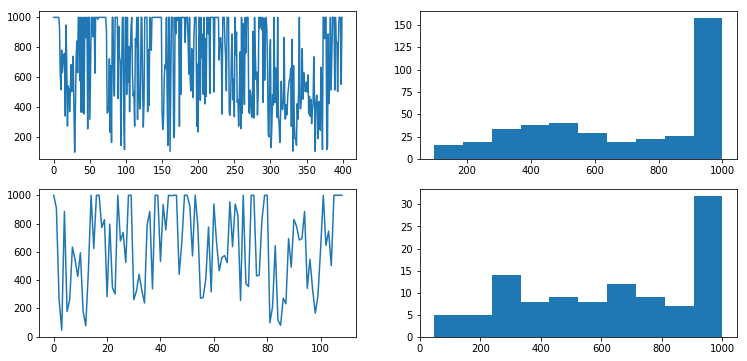

In [ ]:
figsize(12.5, 6)

plt.subplot(221)
plt.plot(ns[:400])

plt.subplot(222)
plt.hist(ns[:400], bins=10)

plt.subplot(223)
plt.plot(ns[400:])

plt.subplot(224)
plt.hist(ns[400:], bins=10)

print('total number of scenes: ', len(ns))
print('train: ', np.sum(ns[:400]))
print('valid: ', np.sum(ns[400:]))

In [ ]:
p0 = Path('../../../data/nyu_depth_v2_aligned/bookstore_0001d')
p1 = Path('../../../data/nyu/train')
p1_r = p1 / 'rgb'
p1_d = p1 / 'depth'

i = 0
while os.path.exists(p0 / '{}.ppm'.format(i)):
    shutil.copy(p0 / '{}.ppm'.format(i), p1_r / '{}.ppm'.format(i))
    shutil.copy(p0 / '{}.pgm'.format(i), p1_d / '{}.pgm'.format(i))
    i += 1

# 3d modeling

In [ ]:
from PIL import Image as ImagePIL
img = ImagePIL.open('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/train/rgb/155.ppm')
dpth = ImagePIL.open('/content/drive/MyDrive/Colab Notebooks/Master paper work -- code/SingleImageDepth_2/data/train/depth/155.pgm')
depth = transforms.ToTensor()(dpth).view(480, 640)
image = transforms.ToTensor()(img).view(480, 640, 3)
print(depth.size())


torch.Size([480, 640])


In [ ]:
img.save("image.jpg")
dpth.save("depth.png")

In [ ]:
import cv2
im = ImagePIL.open("image.jpg")
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')
        
        
#generating 3d point cloud
disp = np.float32(depth)
im_f = np.float32(im)
print('generating 3d point cloud...',)
h, w = im_f.shape[:2]
f = 0.8*w                   # guess for focal length

#disparity-to-depth mapping matrix
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv2.reprojectImageTo3D(disp, Q)
colors = cv2.cvtColor(np.float32(im), cv2.COLOR_BGR2RGB)
mask = disp > disp.mean() #с маской все работает в MeshLab, без маски - не открывает из-за наличия нулевых столбцов
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'out3.ply'
write_ply('out3.ply', out_points, out_colors)
print('%s saved' % 'out2.ply')

generating 3d point cloud...
out2.ply saved
